<a href="https://colab.research.google.com/github/nurjan84/dc-tts-keras/blob/master/dc_tts_keras_10_05_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Keras implementation of [Efficiently Trainable Text-to-Speech System Based on Deep Convolutional Networks with Guided Attention](https://arxiv.org/abs/1710.08969) based on the following projects:

https://github.com/Kyubyong/dc_tts

https://github.com/tugstugi/pytorch-dc-tts

My goals are to learn the deep neural networks and to experiment with training and synthesizing Kazakh language Text-To-Speech. Used 1h:25m single speaker dataset. You can check the synthesized results below.

In [0]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cc666d83-a6a0-85cc-6ae6-807d3504f6c0)


# Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Dependecies

In [0]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

In [0]:
!pip install -r /content/drive/My\ Drive/dc-tts-keras/requirements.txt

# tensorflow-gpu==2.1.0
# tensorboardcolab
# librosa
# matplotlib
# numpy
# scipy
# tqdm

In [0]:
import argparse
import numpy as np
import unicodedata
import re
import codecs
from tqdm import tqdm
from tqdm import tqdm_notebook
import librosa
import pickle
import os, copy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as Kb
import random
import argparse
import scipy
from scipy.io.wavfile import write
import IPython
from IPython.display import Audio
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback


# HyperParameters

In [0]:
class HyperParameters:
    # signal processing
    sampling_rate = 22050  # Sampling rate.
    n_fft = 2048  # fft points (samples)
    frame_shift = 0.0125  # seconds
    frame_length = 0.05  # seconds
    hop_length = int(sampling_rate * frame_shift)  # samples. =276.
    win_length = int(sampling_rate * frame_length)  # samples. =1102.
    n_mels = 80  # Number of Mel banks to generate
    n_mags = 1025  # Number of Mag banks to generate
    power = 1.5  # Exponent for amplifying the predicted magnitude
    n_iter = 50  # Number of inversion iterations
    preemphasis = .97
    max_db = 100
    ref_db = 20

    # Model
    reduction_factor = 4  # Reduction factor. Do not change this.
    dropout_rate = 0.005
    embedding_dimension = 128  # == embedding
    text2mel_dimension = 256  # == hidden units of Text2Mel
    c = 512  # == hidden units of SSRN
    attention_win_size = 3

    # data
    vocab = "PE аәбвгғдеёжзийкқлмнңоөпрстуұүфхһцчшщъыіьэюя,.?"  # P: Padding, E: EOS
    logdir = "logdir/ALU"
    data = "data/alusha/"
    max_N = 212  # Maximum number of characters.
    max_T = 310  # Maximum number of mel frames.
    max_M = 1200  # Maximum number of mel frames.

    # training scheme
    lr = 0.005  # Initial learning rate.
    checkpoint_dir = "logdir/checkpoints_kaz/"
    checkpoint_ssrn_dir = "logdir/checkpoints_ssrn_kaz/"
    sampledir = 'samples'
    B = 32  # batch size


# Utils

In [0]:
def invert_spectrogram(spectrogram):
    '''Applies inverse fft.
    Args:
      spectrogram: [1+n_fft//2, t]
    '''
    return librosa.istft(spectrogram, HyperParameters.hop_length, win_length=HyperParameters.win_length, window="hann")


def griffin_lim(spectrogram):
    '''Applies Griffin-Lim's raw.'''
    X_best = copy.deepcopy(spectrogram)
    for i in range(HyperParameters.n_iter):
        X_t = invert_spectrogram(X_best)
        est = librosa.stft(X_t, HyperParameters.n_fft, HyperParameters.hop_length, win_length=HyperParameters.win_length)
        phase = est / np.maximum(1e-8, np.abs(est))
        X_best = spectrogram * phase
    X_t = invert_spectrogram(X_best)
    y = np.real(X_t)

    return y


def spectrogram2wav(mag):
    '''# Generate wave file from linear magnitude spectrogram

    Args:
      mag: A numpy array of (T, 1+n_fft//2)

    Returns:
      wav: A 1-D numpy array.
    '''
    # transpose
    mag = mag.T

    # de-noramlize
    mag = (np.clip(mag, 0, 1) * HyperParameters.max_db) - HyperParameters.max_db + HyperParameters.ref_db

    # to amplitude
    mag = np.power(10.0, mag * 0.05)

    # wav reconstruction
    wav = griffin_lim(mag**HyperParameters.power)

    # de-preemphasis
    wav = signal.lfilter([1], [1, -HyperParameters.preemphasis], wav)

    # trim
    wav, _ = librosa.effects.trim(wav)

    return wav.astype(np.float32)


def get_spectrograms(fpath):
    """
    Parse the wave file in `fpath` and
    Returns normalized melspectrogram and linear spectrogram.

    Args:
      fpath: A string. The full path of a sound file.

    Returns:
      mel: A 2d array of shape (T, n_mels) and dtype of float32.
      mag: A 2d array of shape (T, 1+n_fft/2) and dtype of float32.
    """
    # Loading sound file
    y, sr = librosa.load(fpath, sr=HyperParameters.sampling_rate)

    # Trimming
    y, _ = librosa.effects.trim(y)

    # Preemphasis
    y = np.append(y[0], y[1:] - HyperParameters.preemphasis * y[:-1])

    # stft
    linear = librosa.stft(
        y=y,
        n_fft=HyperParameters.n_fft,
        hop_length=HyperParameters.hop_length,
        win_length=HyperParameters.win_length
    )

    # magnitude spectrogram
    mag = np.abs(linear)  # (1+n_fft//2, T)

    # mel spectrogram
    mel_basis = librosa.filters.mel(HyperParameters.sampling_rate, HyperParameters.n_fft, HyperParameters.n_mels)  # (n_mels, 1+n_fft//2)
    mel = np.dot(mel_basis, mag)  # (n_mels, t)

    # to decibel
    mel = 20 * np.log10(np.maximum(1e-5, mel))
    mag = 20 * np.log10(np.maximum(1e-5, mag))

    # normalize
    mel = np.clip((mel - HyperParameters.ref_db + HyperParameters.max_db) / HyperParameters.max_db, 1e-8, 1)
    mag = np.clip((mag - HyperParameters.ref_db + HyperParameters.max_db) / HyperParameters.max_db, 1e-8, 1)

    # Transpose
    mel = mel.T.astype(np.float32)  # (T, n_mels)
    mag = mag.T.astype(np.float32)  # (T, 1+n_fft//2)

    return mel, mag


def guided_attention(g=0.2):
    '''Guided attention. Refer to page 3 on the paper.'''
    W = np.zeros((HyperParameters.max_N, HyperParameters.max_T), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(HyperParameters.max_T) - n_pos / float(HyperParameters.max_N)) ** 2 / (2 * g * g))
    return W


def current_guided_attention(current_n, current_t, g=0.2):
    W = np.zeros((current_n, current_t), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(current_t) - n_pos / float(current_n)) ** 2 / (2 * g * g))
    return W


def plot_and_save_alignment(alignment, epoch, dir=HyperParameters.logdir, logs=None):
    """Plots the alignment.

    Args:
      alignment: A numpy array with shape of (encoder_steps, decoder_steps)
      gs: (int) global step.
      dir: Output path.
      logs:
    """
    if not os.path.exists(dir): os.mkdir(dir)

    plt.rc('font', size=8)
    fig, ax = plt.subplots()
    plt.margins(0.1, 0.1)
    # fig.set_size_inches(5, 5)
    # print("plot_alignment {}".format(logs))

    ax.set_xlabel(logs.get('file_name') + '\n total loss = {0:.4f}, Y activated loss = {1:.4f}, Y logit loss = {2:.4f}, A loss = {3:.6f}'
                  .format(logs.get('loss'), logs.get('Y_activation_loss'), logs.get('Y_logits_loss'), logs.get('attention_loss')))

    im = ax.imshow(alignment)

    fig.colorbar(im)
    plt.title('{} Epoch, {} lr'.format(epoch, logs.get('lr')))
    plt.savefig('{}/alignment_{}.png'.format(dir, epoch), format='png', dpi=300)
    plt.show()
    plt.close(fig)


def plot_alignment(alignment): 
    fig, ax = plt.subplots()
    im = ax.imshow(alignment)
    fig.colorbar(im)
    plt.show()
    plt.close(fig)


In [0]:
plot_alignment(guided_attention(g=0.2))

In [0]:
def learning_rate_decay(init_lr, step, warmup_steps = 4000.0):
    return init_lr * warmup_steps**0.5 * tf.minimum(step * warmup_steps**-1.5, step**-0.5)
new_lr = learning_rate_decay(0.001, 100000, warmup_steps = 4000.0)
print("new lr = {}".format(new_lr))

new lr = 0.0001999999803956598


# Preprocess Data

In [0]:
base_dir = "/content/drive/My Drive/dc-tts-keras/"
char2idx = {char: idx for idx, char in enumerate(HyperParameters.vocab)} 
mels = os.path.join(base_dir, 'mels_kaz')
mags = os.path.join(base_dir, 'mags_kaz')
raw_mels_length_pickle = "raw_mels_length_kaz.pickle"
mels_padded_training_dir = base_dir + "kaz_mels_padded_training"
mags_padded_training_dir = base_dir + "kaz_mags_padded_training"
training_text_padded_pickle = base_dir + "kaz_training_text_padded.pickle"
file_names_pickle = base_dir + "kaz_file_names.pickle"
sorted_file_names_pickle = base_dir + "kaz_sorted_file_names.pickle"
texts_not_padded_pickle = base_dir + "kaz_training_text_not_padded.pickle"
texts_sorted_not_padded_pickle = base_dir + "kaz_training_sorted_text_not_padded.pickle"

def get_file_paths():
    paths = []
    file_names = []
    texts = []
    transcript = os.path.join(base_dir + HyperParameters.data, 'metadata.csv')
    lines = codecs.open(transcript, 'r', 'utf-8').readlines()
    for line in lines:
        f_name, text = line.strip().split("|")
        f_path = os.path.join(base_dir + HyperParameters.data, "wavs", f_name + ".wav")
        paths.append(f_path)
        file_names.append(f_name)
        texts.append(text)

    return paths, file_names, texts


def load_spectrograms(files_path):
    """
    Read the wave file in `files_path`
    and extracts spectrogrames
    """

    fname = os.path.basename(files_path)
    mel, mag = get_spectrograms(files_path)
    t = mel.shape[0]

    # Marginal padding for reduction shape sync.
    num_paddings = HyperParameters.reduction_factor - (t % HyperParameters.reduction_factor) if t % HyperParameters.reduction_factor != 0 else 0
    mel = np.pad(mel, [[0, num_paddings], [0, 0]], mode="constant")
    mag = np.pad(mag, [[0, num_paddings], [0, 0]], mode="constant")

    # Reduction
    mel = mel[::HyperParameters.reduction_factor, :]
    return fname, mel, mag


def pre_process_first_step():
    file_paths, _, _ = get_file_paths()  # list

    max_mel_length = 0
    max_mag_length = 0

    if not os.path.exists(mels): os.mkdir(mels)
    if not os.path.exists(mags): os.mkdir(mags)

    raw_mels_length = np.zeros(len(file_paths), np.int32)

    for i, file_path in enumerate(tqdm_notebook(file_paths)):
        file_name, mel_spec, mag_spec = load_spectrograms(file_path)
        np.save(mels + "/{}".format(file_name.replace("wav", "npy")), mel_spec)
        np.save(mags + "/{}".format(file_name.replace("wav", "npy")), mag_spec)
        raw_mels_length[i] = mel_spec.shape[0]
        mel_length = len(mel_spec)
        if max_mel_length < mel_length:
            max_mel_length = mel_length
        mag_length = len(mag_spec)
        if max_mag_length < mag_length:
            max_mag_length = mag_length

    pickle_out = open(base_dir + raw_mels_length_pickle, "wb")
    pickle.dump(raw_mels_length, pickle_out)
    pickle_out.close()
    # max_mel_length = 203
    # max_mag_length = 812
    print("max mel length = {}".format(max_mel_length))
    print("max mag length = {}".format(max_mag_length))


def sort_mel_names_by_text_length():
    _, file_names, raw_texts = get_file_paths()
    texts_sizes = []
    sorted_texts_sizes = []
    sorted_texts = []
    indexes = []
    sorted_file_names = []

    print("file_names len = {}".format(len(file_names)))
    # print("file_names = {}".format(file_names))
    
    for i, text in enumerate(tqdm_notebook(raw_texts)):
      text = text_normalize(text) + "E"  # E: EOS
      text = [char2idx[char] for char in text]
      texts_sizes.append(len(text))
      indexes.append(i)
    
    print("text max = {}".format(max(texts_sizes)))

    sorted_indexes = [x for _,x in sorted(zip(texts_sizes, indexes))]
    # print("sorted_indexes = {}".format(sorted_indexes))
    norm_texts = []
    for i in tqdm_notebook(sorted_indexes):
      text = raw_texts[i]
      text = text_normalize(text) + "E"  # E: EOS
      norm_texts.append(text)
      text = [char2idx[char] for char in text]
      sorted_texts.append(text)
      sorted_file_names.append(file_names[i])
      sorted_texts_sizes.append(len(text))

    # print("texts_sizes = {}".format(texts_sizes))
    # print("sorted texts_sizes = {}".format(sorted_texts_sizes))
    # print("sorted_file_names = {}".format(sorted_file_names))
    print("norm_text = {}".format(norm_texts[0]))
    print("sorted_text = {}".format(sorted_texts[0]))
    pickle_out = open(sorted_file_names_pickle, "wb")
    pickle.dump(sorted_file_names, pickle_out)
    pickle_out.close()
    pickle_out = open(texts_sorted_not_padded_pickle, "wb")
    pickle.dump(sorted_texts, pickle_out)
    pickle_out.close()


def text_normalize(text):
  text = ''.join(char for char in unicodedata.normalize('NFC', text) if unicodedata.category(char) != 'Mn')  # Strip accents
  text = text.lower()
  text = re.sub("[^{}]".format(HyperParameters.vocab), " ", text)
  text = re.sub("[ ]+", " ", text)
  return text

def pad_spectrograms(x, target_length):
    return np.pad(x, ((0, target_length - len(x)), (0, 0)), mode='constant', constant_values=0)

def pad_texts(x, target_length):
    return np.pad(x, (0, target_length - len(x)), mode='constant', constant_values=char2idx['P'])

In [0]:
# converting wav to npy

pre_process_first_step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



max mel length = 300
max mag length = 1200


In [0]:
sort_mel_names_by_text_length()

file_names len = 1047


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



text max = 212


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



norm_text = үйде домофон тұр.E
sorted_text = [30, 15, 9, 10, 2, 9, 22, 19, 22, 31, 22, 20, 2, 27, 29, 25, 46, 1]


# Network

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv1D, Dropout, Conv2DTranspose, \
    Embedding, LayerNormalization, Activation, Lambda, BatchNormalization, Concatenate


def hc(tensor, dilation_rate, kernel_size=3, dropout_rate=HyperParameters.dropout_rate, padding='same', activation='sigmoid'):
    inputs_tensor = tensor

    f = tensor.shape.as_list()[-1] * 2
    # initializer = keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
    initializer = 'VarianceScaling'
    tensor = Conv1D(filters=f,
                    kernel_size=kernel_size,
                    dilation_rate=dilation_rate,
                    # kernel_initializer=initializer,
                    use_bias=True,
                    padding=padding)(tensor)

    def split(x):
        import tensorflow
        return tensorflow.split(x, 2, -1)

    h1, h2 = Lambda(split)(tensor)
    # print("h1 {}".format(h1.shape))
    # print("h2  {}".format(h2.shape))
    h1 = LayerNormalization()(h1)
    h2 = LayerNormalization()(h2)
    # h1 = BatchNormalization()(h1)
    # h2 = BatchNormalization()(h2)
    h1 = Activation(activation)(h1)

    def some_math(x):
        return x[0] * x[1] + (1. - x[0]) * x[2]

    tensor = Lambda(some_math)([h1, h2, inputs_tensor])
    tensor = Dropout(rate=dropout_rate)(tensor)
  
    return tensor

def conv1(tensor, filters=None, dilation_rate=1, kernel_size=3, padding='same', activation=None, dropout_rate=HyperParameters.dropout_rate, name=None):

    if filters is None:
        filters = tensor.shape.as_list()[-1]

    # initializer = keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
    initializer = 'VarianceScaling'
    tensor = Conv1D(filters=filters,
                    kernel_size=kernel_size,
                    dilation_rate=dilation_rate,
                    padding=padding,
                    # kernel_initializer=initializer,
                    use_bias=True
                    )(tensor)

    tensor = LayerNormalization()(tensor)
    # tensor = BatchNormalization()(tensor)
    if activation is not None:
        tensor = Activation(activation)(tensor)

    tensor = Dropout(rate=dropout_rate, name=name)(tensor)

    return tensor

def conv1d_transpose(tensor, kernel_size=3, stride=2, dropout_rate=HyperParameters.dropout_rate):
    
    f = tensor.get_shape().as_list()[-1]

    def expand_dims(x):
        import tensorflow as tf
        return tf.expand_dims(x, 1)

    tensor = Lambda(expand_dims)(tensor)
    tensor = Conv2DTranspose(filters=f,
                             kernel_size=(1, kernel_size),
                             strides=(1, stride),
                             use_bias=True,
                             padding='same')(tensor)

    def squeeze_dims(x):
        import tensorflow as tf
        return tf.squeeze(x, 1)

    tensor = Lambda(squeeze_dims)(tensor)
    tensor = LayerNormalization()(tensor)
    tensor = Dropout(rate=dropout_rate)(tensor)
    return tensor

def text_enc(input_encoder, max_char=HyperParameters.max_N, e=HyperParameters.embedding_dimension, d=HyperParameters.text2mel_dimension, vocab=HyperParameters.vocab):

    print("TextEnc vocab = {}".format(vocab))
    print("TextEnc input_encoder shape = {}".format(input_encoder.shape))
    ini = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)
    
    lookup_table = scipy.stats.truncnorm.rvs(-0.2, 0.2, size=len(vocab)*e)
    lookup_table = np.reshape(lookup_table, (len(vocab), e))
    lookup_table[0] = np.zeros(shape=(1,e), dtype=np.float32)
    ini = tf.initializers.constant(lookup_table)
    
    # tensor = Embedding(input_dim=len(vocab), output_dim=e, mask_zero=False, embeddings_initializer=ini)(input_encoder)
    tensor = Embedding(
                      input_dim=len(vocab),
                      output_dim=e, 
                      mask_zero=True,
                      # embeddings_initializer=ini
                      )(input_encoder)
    
    print("TextEnc tensor Embedding shape = {}".format(tensor.shape))

    tensor = conv1(tensor, filters=2 * d, kernel_size=1, dilation_rate=1, padding='same', activation='relu')

    print("TextEnc tensor1 shape = {}".format(tensor.shape))

    tensor = conv1(tensor, kernel_size=1, dilation_rate=1, padding='same')

    print("TextEnc tensor2 shape = {}".format(tensor.shape))

    for _ in range(2):
        for j in range(4):
            tensor = hc(tensor, kernel_size=3, dilation_rate=3 ** j)

    print("TextEnc tensor3 shape = {}".format(tensor.shape))

    for _ in range(2):
        tensor = hc(tensor, kernel_size=3, dilation_rate=1)

    print("TextEnc tensor4 shape = {}".format(tensor.shape))

    for _ in range(2):
        tensor = hc(tensor, kernel_size=1, dilation_rate=1)

    print("TextEnc tensor5 shape = {}".format(tensor.shape))

    def split(x):
        import tensorflow
        return tensorflow.split(x, 2, -1)

    K, V = Lambda(split)(tensor)

    print("TextEnc K shape = {}".format(K.shape))
    print("TextEnc V shape = {}".format(V.shape))
    return K, V

def audio_enc(input_decoder, d=HyperParameters.text2mel_dimension):

    print("audio_enc shape = {}".format(input_decoder.shape))

    def prepare_S(mels):
      import tensorflow
      return tensorflow.concat((tensorflow.zeros_like(mels[:, :1, :]), mels[:, :-1, :]), 1)
    
    tensor = Lambda(prepare_S)(input_decoder)

    tensor = conv1(tensor, filters=d, kernel_size=1, dilation_rate=1, padding='causal', activation='relu')

    print("audio_enc tensor1 shape = {}".format(tensor.shape))

    tensor = conv1(tensor, kernel_size=1, dilation_rate=1, padding='causal', activation='relu')

    print("audio_enc tensor2 shape = {}".format(tensor.shape))

    tensor = conv1(tensor, kernel_size=1, dilation_rate=1, padding='causal')

    print("audio_enc tensor3 shape = {}".format(tensor.shape))

    for _ in range(2):
        for j in range(4):
            tensor = hc(tensor, kernel_size=3, dilation_rate=3 ** j, padding='causal')

    print("audio_enc tensor4 shape = {}".format(tensor.shape))

    for _ in range(2):
        tensor = hc(tensor, kernel_size=3, dilation_rate=3, padding='causal')

    print("audio_enc tensor5 shape = {}".format(tensor.shape))

    return tensor

def audio_dec(R, d=HyperParameters.text2mel_dimension, n_mels=HyperParameters.n_mels):

    print("audio_dec R = {}".format(R.shape))

    tensor = conv1(R, filters=d, kernel_size=1, dilation_rate=1, padding='causal')

    print("audio_dec tensor1 = {}".format(tensor.shape))

    for j in range(4):
        tensor = hc(tensor, kernel_size=3, dilation_rate=3 ** j, padding='causal')

    print("audio_dec tensor2 = {}".format(tensor.shape))

    for _ in range(2):
        tensor = hc(tensor, kernel_size=3, dilation_rate=1, padding='causal')

    print("audio_dec tensor3 = {}".format(tensor.shape))

    for _ in range(3):
        tensor = conv1(tensor, kernel_size=1, dilation_rate=1, padding='causal', activation='relu')

    print("audio_dec tensor4 = {}".format(tensor.shape))

    logits = conv1(tensor, filters=n_mels, kernel_size=1, dilation_rate=1, padding='causal', name='Y_logits')

    Y = Activation(activation='sigmoid', name='Y_activation')(logits)

    print("audio_dec logits = {}".format(logits.shape))
    print("audio_dec Y = {}".format(Y.shape))

    return Y, logits

def attention(x):
    import tensorflow
    from tensorflow.keras import backend as Kb
    Q = x[0]
    K = x[1]
    V = x[2]
    mononotic_attention = Kb.learning_phase() == 0

    print("mononotic_attention = {}".format(mononotic_attention))
    # Q = Kb.print_tensor(Q, message='Q = ')
    # K = Kb.print_tensor(K, message='K = ')
    # V = Kb.print_tensor(V, message='V = ')

    A = tensorflow.matmul(Q, K, transpose_b=True) * tensorflow.math.rsqrt(tensorflow.cast(HyperParameters.text2mel_dimension, tensorflow.float32))
    # print("Attention A shape = {}".format(A.shape))
    if mononotic_attention:
        prev_max_attentions = x[3]
        key_masks = tensorflow.sequence_mask(prev_max_attentions, HyperParameters.max_N)
        # print("key_masks = {}".format(key_masks.shape))
        reverse_masks = tensorflow.sequence_mask(HyperParameters.max_N - HyperParameters.attention_win_size - prev_max_attentions, HyperParameters.max_N)[:, ::-1]
        # print("reverse_masks = {}".format(reverse_masks.shape))
        masks = tensorflow.logical_or(key_masks, reverse_masks)
        # print("masks = {}".format(masks.shape))
        masks = tensorflow.tile(tensorflow.expand_dims(masks, 1), [1, HyperParameters.max_T, 1])
        # print("masks = {}".format(masks.shape))
        paddings = tensorflow.ones_like(A) * (-2 ** 32 + 1)  
        A = tensorflow.where(tensorflow.equal(masks, False), A, paddings)

    A = tensorflow.nn.softmax(A)  
    max_attentions = tensorflow.argmax(A, -1)
    R = tensorflow.matmul(A, V)
    R = tensorflow.concat((R, Q), -1)
    alignments = tensorflow.transpose(A, [0, 2, 1]) 
    return R, max_attentions, alignments

def get_text2mel_model(input_encoder, input_decoder, prev_attention):
    K, V = text_enc(input_encoder)
    Q = audio_enc(input_decoder)
    R, max_attentions, alignments = Lambda(attention, name='attention')([Q, K, V, prev_attention])

    Y, Y_logits = audio_dec(R)

    model = Model(inputs=[input_encoder, input_decoder, prev_attention], outputs=[Y, Y_logits, alignments, max_attentions])

    return model

def SSRN(input_tensor, filters=HyperParameters.c, dropout_rate=HyperParameters.dropout_rate):

    print("SSRN Y shape = {}".format(input_tensor.shape))

    tensor = conv1(input_tensor,
                  filters=filters,
                  kernel_size=1,
                  dilation_rate=1)

    print("SSRN tensor1 shape = {}".format(tensor.shape))

    for j in range(2):
        tensor = hc(tensor, kernel_size=3, dilation_rate=3 ** j)

    print("SSRN tensor2 shape = {}".format(tensor.shape))

    for _ in range(2):
        tensor = conv1d_transpose(tensor)
        print("SSRN tensor transpose shape = {}".format(tensor.shape))
        for j in range(2):
            tensor = hc(tensor, kernel_size=3, dilation_rate=3 ** j)

    print("SSRN tensor3 shape = {}".format(tensor.shape))

    tensor = conv1(tensor,
                  filters=2*filters,
                  kernel_size=1,
                  dilation_rate=1)

    print("SSRN tensor4 shape = {}".format(tensor.shape))

    for _ in range(2):
        tensor = hc(tensor, kernel_size=3, dilation_rate=1)

    print("SSRN tensor5 shape = {}".format(tensor.shape))

    tensor = conv1(tensor,
                  filters=(1 + HyperParameters.n_fft // 2),
                  kernel_size=1,
                  dilation_rate=1)

    print("SSRN tensor6 shape = {}".format(tensor.shape))

    for _ in range(2):
      tensor = conv1(tensor,
                  kernel_size=1,
                  dilation_rate=1,
                  activation="relu")

    print("SSRN tensor7 shape = {}".format(tensor.shape))

    logits = conv1(tensor,
                  kernel_size=1,
                  dilation_rate=1,
                  name="Z_logits")

    Z = Activation('sigmoid', name="Z")(logits)

    print("SSRN tensor8 shape = {}".format(Z.shape))

    return Z, logits

def get_SSRN_model(input_tensor):
    Z, Z_logits = SSRN(input_tensor)
    model = Model(inputs=input_tensor, outputs=[Z, Z_logits])
    return model


# Text2Mel data generator

In [0]:
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, base_dir, list_mel_names, batch_size):
        self.indexes = np.arange(len(list_mel_names))
        self.batch_size = batch_size
        self.base_dir = base_dir
        self.list_mel_names = list_mel_names

    def __len__(self):
        return int(np.floor(len(self.list_mel_names) / self.batch_size))

    def __getitem__(self, index):
      
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        random.shuffle(indexes)

        def getMels(mel_names_list):
          mels_arr = []
          mags_arr = []
          mel_max = 0
          mag_max = 0
          for name in mel_names_list:
            mel = mels + "/{}".format(name + '.npy')
            mag = mags + "/{}".format(name + '.npy')
            mel = np.load(mel)
            mag = np.load(mag)
            mels_arr.append(mel)
            mags_arr.append(mag)
            
            mel_len = mel.shape[0]
            mag_len = mag.shape[0]

            if(mel_max < mel_len):
              mel_max = mel_len

            if(mag_max < mag_len):
              mag_max = mag_len

          return mels_arr, mel_max, mags_arr, mag_max

        file_names = [self.list_mel_names[k] for k in indexes]
        list_mels_temp, mels_max, list_mags_temp, mags_max = getMels(file_names)
    
        # Generate data
        X, y = self.__data_generation(list_mels_temp, mels_max, list_mags_temp, mags_max)

        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __data_generation(self, list_mels_temp, mels_max, list_mags_temp, mags_max):
      
        mels_np = np.zeros(shape=(self.batch_size, mels_max, HyperParameters.n_mels))
        mags_np = np.zeros(shape=(self.batch_size, mags_max, HyperParameters.n_mags))

        for i in range(len(list_mels_temp)):
            mels_np[i] = pad_spectrograms(list_mels_temp[i], mels_max)
            mags_np[i] = pad_spectrograms(list_mags_temp[i], mags_max)
 
        return mels_np, [mags_np, mags_np]


class DataGenerator2(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, base_dir, list_text_np, list_mel_names,  batch_size):
        self.indexes = np.arange(len(list_mel_names))
        self.batch_size = batch_size
        self.base_dir = base_dir
        self.list_text_np = list_text_np
        self.list_mel_names = list_mel_names
        self.guided_attention = guided_attention()

    def __len__(self):
        return int(np.floor(len(self.list_mel_names) / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # indexes = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

        random.shuffle(indexes)

        def getMels(mel_names_list):
          mels_arr = []
          mel_max = 0
          for name in mel_names_list:
            mel = mels + "/{}".format(name + '.npy')
            mel = np.load(mel)
            mels_arr.append(mel)
            mel_len = mel.shape[0]
            if(mel_max < mel_len):
              mel_max = mel_len
          return mels_arr, mel_max

        # Find list of IDs
        # print("indexes = {}".format(indexes))
        file_names = [self.list_mel_names[k] for k in indexes]
        list_mels_temp, mels_max = getMels(file_names)
        list_texts_temp = [self.list_text_np[k] for k in indexes]

        def get_text_max(list):
          max_t = 0
          for t in list:
            l = len(t)
            if(max_t < l):
              max_t = l
          return max_t
        text_max = get_text_max(list_texts_temp)
        # text_max = len(list_texts_temp[self.batch_size-1])
       
        # Generate data
        X, y = self.__data_generation(list_mels_temp, list_texts_temp, mels_max, text_max)

        return X, y

    # def on_epoch_end(self):
    #   np.random.shuffle(self.indexes)

    def __data_generation(self, list_mels_temp, list_texts_temp, mels_max, text_max):
        # print("list_mels_temp = {}, mel max = {}, text max = {}".format(len(list_mels_temp), mels_max, text_max))
        mels_max = mels_max + 0
        text_max = text_max + 0
        mels = np.zeros(shape=(self.batch_size, mels_max, HyperParameters.n_mels))
        texts = np.zeros(shape=(self.batch_size, text_max), dtype=np.int32)
        batch_y_att = np.zeros(shape=(self.batch_size, HyperParameters.max_N, HyperParameters.max_T))

        for i in range(len(list_mels_temp)):
            mels[i] = pad_spectrograms(list_mels_temp[i], mels_max)
            texts[i] = pad_texts(list_texts_temp[i], text_max) 
            batch_y_att[i] = self.guided_attention

        # print(f"att shape = {batch_y_att.shape}")

        prev_max_attentions = np.zeros((self.batch_size,), np.int32)

        return [texts, mels, prev_max_attentions], [mels, mels, batch_y_att]

# Text2Mel training callbacks

In [0]:
class TrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self, base_dir, training_texts_np, list_mel_names):
        super().__init__()
        self.base_dir = base_dir
        self.training_texts_np = training_texts_np
        self.list_mel_names = list_mel_names

    def getMel(self, idx):
        mel = mels + "/{}".format(self.list_mel_names[idx]+'.npy')
        Y = np.load(mel)
        Y = pad_spectrograms(Y, Y.shape[0] + 0)
        Y = np.expand_dims(Y, axis=0)
        return Y

    def on_epoch_end(self, epoch, logs=None):
        index = random.randint(0,1045)
        # index = 1
        lr = Kb.eval(self.model.optimizer.lr)
        logs['lr'] = lr
        logs['file_name'] = self.list_mel_names[index]

        L = self.training_texts_np[index]
        Y = self.getMel(index)
        L = np.expand_dims(L, axis=0)
        prev_max_attentions = np.zeros((len(L),), np.int32)

        # print(" ")
        # print("file name = {}".format(self.list_mel_names[index]))
        # print("L = {}".format(L))
        # print("Y = {}".format(Y))
        # print("Y0 = {}".format(Y0))

        _, _, alig, _ = self.model.predict(x=[L, Y, prev_max_attentions])
        plot_and_save_alignment(alig[0], epoch, self.base_dir + HyperParameters.logdir, logs)


class LearningRateDecay(tf.keras.callbacks.Callback):
  def __init__(self, gs=0):
      self.init_learining_rate = HyperParameters.lr
      self.global_step = gs

  def lr_decay(self, step, warmup_steps = 4000):
    step = step + 1
    return self.init_learining_rate * warmup_steps**0.5 * min(step * warmup_steps**-1.5, step**-0.5)

  def on_batch_begin(self, batch, logs=None):
    actual_lr = float(Kb.get_value(self.model.optimizer.lr))
    decayed_learning_rate = self.lr_decay(self.global_step)
    Kb.set_value(self.model.optimizer.lr, decayed_learning_rate)
    self.global_step += 1
  
  def on_epoch_end(self, epoch, logs=None):
      lr = Kb.eval(self.model.optimizer.lr)
      print(" ")
      print("lr = {}, step = {}".format(lr, self.global_step))


def lr_decay(step, warmup_steps = 4000):
    step = step + 1
    return 0.005 * warmup_steps**0.5 * min(step * warmup_steps**-1.5, step**-0.5)

In [0]:
print(lr_decay(4000))

7.907670573958555e-05


# Training

In [0]:
text2mel_model = 'text2mel_model_kaz.h5'
ssrn_model = 'ssrb_model_kaz_1.h5'

# def mae_loss(y_true, y_pred):
#     loss_mels = tf.reduce_mean(tf.abs(y_pred - y_true))
#     return loss_mels

def mae_loss(y_true, y_pred):
    return keras.losses.mean_absolute_error(y_true, y_pred)

# def y_logits_loss(y_true, y_pred):
#     loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))
#     return loss_bd1

def y_logits_loss(y_true, y_pred):
  return Kb.mean(tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True))


def attention_loss(y_true, y_pred):
    guided_att = tf.convert_to_tensor(y_true)
    A = tf.pad(y_pred, [(0, 0), (0, HyperParameters.max_N), (0, HyperParameters.max_T)], mode="CONSTANT", constant_values=-1.)[:, :HyperParameters.max_N, :HyperParameters.max_T]
    attention_masks = tf.cast(tf.not_equal(A, -1), tf.float32)
    loss_att = tf.reduce_sum(tf.abs(A * guided_att) * attention_masks)
    mask_sum = tf.reduce_sum(attention_masks)
    loss_att /= mask_sum
    return loss_att


def train_text_to_mel_model():
  
    training_texts_np = pickle.load(open(texts_sorted_not_padded_pickle, "rb"))
    mel_training_file_names = pickle.load(open(sorted_file_names_pickle, "rb"))

    training_data = DataGenerator2(
        base_dir=base_dir,
        list_text_np=training_texts_np,
        list_mel_names=mel_training_file_names,
        batch_size=HyperParameters.B)

    input_encoder = Input(shape=(None,), dtype=np.int32)
    input_decoder = Input(shape=(None, HyperParameters.n_mels))
    prev_max_attention = np.zeros(shape=(HyperParameters.B,), dtype=np.int32)
    prev_attention = Input(shape=prev_max_attention.shape[1:])

    Kb.set_learning_phase(1)

    model = get_text2mel_model(input_encoder, input_decoder, prev_attention)
    # model.summary()
    opt = Adam(learning_rate=HyperParameters.lr, beta_1=0.5, beta_2=0.9)
    model.compile(optimizer=opt, loss=[mae_loss, y_logits_loss, attention_loss, None])
    model.load_weights(base_dir + HyperParameters.checkpoint_dir + 'cp-0005.ckpt')
    
    epoch = 10
    initial_epoch = 5
    steps_per_epoch = 10000
    model.fit(
        initial_epoch=initial_epoch,
        x=training_data,
        steps_per_epoch=steps_per_epoch,
        # use_multiprocessing=True,
        callbacks=[
            ModelCheckpoint(filepath=base_dir + HyperParameters.checkpoint_dir + 'cp-{epoch:04d}.ckpt', save_weights_only=True, verbose=0, save_freq='epoch'),
            # TensorBoard(base_dir + HyperParameters.checkpoint_dir, histogram_freq=1),
            LearningRateDecay(initial_epoch*steps_per_epoch),
            TrainingCallback(base_dir, training_texts_np, mel_training_file_names)
            ],
        epochs=epoch, verbose=1)

    model.save(base_dir + text2mel_model)


def train_SSRN_model():
    mel_training_file_names = pickle.load(open(sorted_file_names_pickle, "rb"))
    
    training_data = DataGenerator(
        base_dir=base_dir,
        list_mel_names=mel_training_file_names,
        batch_size=HyperParameters.B)
    
    input_tensor = Input(shape=(None, HyperParameters.n_mels))
    model = get_SSRN_model(input_tensor)
    # model.load_weights(base_dir + HyperParameters.checkpoint_ssrn_dir + 'ssr_cp-0029.ckpt')

    opt = Adam(learning_rate=0.005, beta_1=0.5, beta_2=0.9)
    model.compile(optimizer=opt, loss=[mae_loss, y_logits_loss])

    epoch = 100
    initial_epoch = 29
    steps_per_epoch = 1000
    model.fit(
        initial_epoch=initial_epoch,
        x=training_data,
        steps_per_epoch=steps_per_epoch,
        callbacks=[
                  LearningRateDecay(initial_epoch*steps_per_epoch),
                  ModelCheckpoint(filepath=base_dir + HyperParameters.checkpoint_ssrn_dir + 'ssr_cp-{epoch:04d}.ckpt', save_weights_only=True, verbose=0, period=1)
                  ],
        epochs=epoch, verbose=1)

    model.save(base_dir + ssrn_model)



In [0]:
# %load_ext tensorboard
%tensorboard --port=5036 --logdir "/content/drive/My Drive/dc-tts-keras/logdir/checkpoints"

GPU 0: Tesla T4 (UUID: GPU-cc666d83-a6a0-85cc-6ae6-807d3504f6c0)
tensorFlow version = 2.1.0
TextEnc vocab = PE аәбвгғдеёжзийкқлмнңоөпрстуұүфхһцчшщъыіьэюя,.?
TextEnc input_encoder shape = (None, None)
TextEnc tensor Embedding shape = (None, None, 128)
TextEnc tensor1 shape = (None, None, 512)
TextEnc tensor2 shape = (None, None, 512)
TextEnc tensor3 shape = (None, None, 512)
TextEnc tensor4 shape = (None, None, 512)
TextEnc tensor5 shape = (None, None, 512)
TextEnc K shape = (None, None, 256)
TextEnc V shape = (None, None, 256)
audio_enc shape = (None, None, 80)
audio_enc tensor1 shape = (None, None, 256)
audio_enc tensor2 shape = (None, None, 256)
audio_enc tensor3 shape = (None, None, 256)
audio_enc tensor4 shape = (None, None, 256)
audio_enc tensor5 shape = (None, None, 256)
mononotic_attention = False
audio_dec R = (None, None, 512)
audio_dec tensor1 = (None, None, 256)
audio_dec tensor2 = (None, None, 256)
audio_dec tensor3 = (None, None, 256)
audio_dec tensor4 = (None, None, 256)


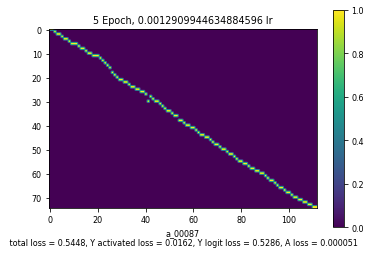

10000/10000 [==============================] - 3616s 362ms/step - loss: 0.5448 - Y_activation_loss: 0.0162 - Y_logits_loss: 0.5286 - attention_loss: 5.0541e-05
Epoch 7/10
 9999/10000 [============================>.] - ETA: 0s - loss: 0.5445 - Y_activation_loss: 0.0159 - Y_logits_loss: 0.5285 - attention_loss: 5.0637e-05 
lr = 0.0011952286586165428, step = 70000


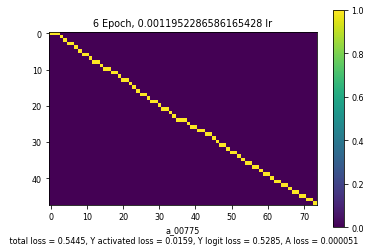

10000/10000 [==============================] - 2306s 231ms/step - loss: 0.5445 - Y_activation_loss: 0.0159 - Y_logits_loss: 0.5285 - attention_loss: 5.0636e-05
Epoch 8/10
 2114/10000 [=====>........................] - ETA: 30:09 - loss: 0.5443 - Y_activation_loss: 0.0158 - Y_logits_loss: 0.5285 - attention_loss: 5.0697e-05

In [0]:
# start text2mel training
!nvidia-smi -L
%matplotlib inline
print("tensorFlow version = {}".format(tf.__version__))
tf.compat.v1.disable_eager_execution()
train_text_to_mel_model()

In [0]:
# start ssrn training
!nvidia-smi -L
%matplotlib inline
print("tensorFlow version = {}".format(tf.__version__))
tf.compat.v1.disable_eager_execution()
train_SSRN_model()

# Synthesize

In [0]:
def prepare_text(text):
    char2idx = {char: idx for idx, char in enumerate(HyperParameters.vocab)}
    sent = text_normalize(text).strip() + "E"
    print("Synthesizing = {}".format(sent))
    text = np.zeros(HyperParameters.max_N, np.int32)
    for i, char in enumerate(sent):
        text[i] = char2idx[char]
    return text


def test_text2mel_model(base_dir):
    SENTENCES_KAZ = [
                    "Мен – қазақпын мың өліп, мың тірілген",
                    "Елімізде қауіпті вирус жұқтырғандар саны тағыда артты",
                    "Аурухана толып қалған",
                    "Ақтөбеде жалған ақпарат таратқан әйел жазаланды",
                    "Әкімдер мен министрлер жауап береді",
                    "Елбасы дағдарыс туралы айтты"
                     ]
   
    Kb.set_learning_phase(0)
    
    Y_model = tf.keras.models.load_model(base_dir + text2mel_model, custom_objects={'mae_loss':mae_loss, 'y_logits_loss':y_logits_loss, 'attention_loss': attention_loss})
    Y_model.load_weights(base_dir + HyperParameters.checkpoint_dir + 'cp-0007.ckpt')
    Z_model = tf.keras.models.load_model(base_dir + ssrn_model,  custom_objects={'mae_loss':mae_loss, 'y_logits_loss':y_logits_loss})
    Z_model.load_weights(base_dir + HyperParameters.checkpoint_ssrn_dir + 'ssr_cp-0050.ckpt')
    
    for l in range(len(SENTENCES_KAZ)):
      
      sent = SENTENCES_KAZ[l]
     
      L = prepare_text(sent)
      L = np.expand_dims(L, axis=0)
     
      Y = np.zeros((1, HyperParameters.max_T, HyperParameters.n_mels), np.float32)
      alig = np.zeros((1, HyperParameters.max_N, HyperParameters.max_T), np.float32)
      prev_max_attentions = np.zeros((1,), np.int32)

      for j in range(HyperParameters.max_T):
          _Y, _, _alig, max_att = Y_model.predict([L, Y, prev_max_attentions])
          Y[:, j, :] = _Y[:, j, :]
          alig[:, :, j] = _alig[:, :, j]
          prev_max_attentions = max_att[:, j]
          if L[0, prev_max_attentions[0]] == HyperParameters.vocab.index('E'):
            break

      # plot_alignment(alig[0])
      # print("Y = {}".format(Y))
      # print("Y max = {}".format(np.amax(Y)))
      # print("prev_max_attentions= {}".format(prev_max_attentions))

      Z, _ = Z_model.predict(Y)
      # print("Z = {}".format(Z))
      # print("Z shape = {}".format(Z.shape))
      for i, mag in enumerate(Z):
          wav = spectrogram2wav(mag)
          write(base_dir + HyperParameters.sampledir + "/{}.wav".format(l), HyperParameters.sampling_rate, wav)

      IPython.display.display(Audio(base_dir + HyperParameters.sampledir + "/{}.wav".format(l), rate=HyperParameters.sampling_rate))


def test_ssrn_model(base_dir):
    def getMel(idx):
        mel_training_file_names = pickle.load(open(sorted_file_names_pickle, "rb"))
        mel_name = mel_training_file_names[idx]
        print(mel_name)
        mel = mels + "/{}".format(mel_name+'.npy')
        Y = np.load(mel)
        Y = np.expand_dims(Y, axis=0)
        return Y
    
    Z_model = tf.keras.models.load_model(base_dir + ssrn_model,  custom_objects={'mae_loss':mae_loss, 'y_logits_loss':y_logits_loss})
    Z_model.load_weights(base_dir + HyperParameters.checkpoint_ssrn_dir + 'ssr_cp-0050.ckpt')
    Y = getMel(1046)
    Z, Z_logits = Z_model.predict(Y)

    print("Y shape = {}".format(Y.shape))
    print("Y = {}".format(Y))
    print("Z = {}".format(Z))
    print("Z shape = {}".format(Z.shape))
    print("Z max = {}".format(np.amax(Z)))

    for i, mag in enumerate(Z):
        print("Working on file", i + 1)
        wav = spectrogram2wav(mag)
        write(base_dir + HyperParameters.sampledir + "/{}.wav".format(i + 1), HyperParameters.sampling_rate, wav)

    IPython.display.display(Audio(base_dir + HyperParameters.sampledir + "/{}.wav".format(1), rate=HyperParameters.sampling_rate))


In [0]:
# text 2 mel model
print(f"tensorFlow version = {tf.__version__}")
!nvidia-smi -L
tf.compat.v1.disable_eager_execution()
test_text2mel_model(base_dir="/content/drive/My Drive/dc-tts-keras/")

tensorFlow version = 2.1.0
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

mononotic_attention = True
Synthesizing = мен қазақпын мың өліп, мың тірілгенE


Synthesizing = елімізде қауіпті вирус жұқтырғандар саны тағыда арттыE


Synthesizing = аурухана толып қалғанE


Synthesizing = ақтөбеде жалған ақпарат таратқан әйел жазаландыE


Synthesizing = әкімдер мен министрлер жауап бередіE


Synthesizing = елбасы дағдарыс туралы айттыE


In [0]:
# ssrn model
print("tensorFlow version = {}".format(tf.__version__))
tf.compat.v1.disable_eager_execution()
test_ssrn_model(base_dir="/content/drive/My Drive/dc-tts-keras/")

tensorFlow version = 2.1.0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
a_00697
Y shape = (1, 300, 80)
Y = [[[0.13056286 0.11189537 0.13620697 ... 0.16983552 0.1765871  0.10262872]
  [0.14214654 0.15520225 0.12056968 ... 0.22809274 0.22516812 0.11466064]
  [0.1494187  0.15917686 0.11759681 ... 0.430356   0.41684926 0.28991708]
  ...
  [0.10003218 0.18207188 0.28507906 ... 0.2647299  0.25782925 0.18329605]
  [0.09510559 0.13286641 0.16340412 ... 0.16178522 0.15410766 0.06918558]
  [0.0295997  0.11874203 0.14168443 ... 0.13948636 0.13328327 0.04837669]]]
Z = [[[3.2240576e-01 3.4849226e-01 3.5598418e-01 ... 9.3078716e-03
   2.2624291e-02 4.4666357e-02]
  [3.2715619e-01 3.6047980e-01 3.7294745e-01 ... 7.0818984e-03
   1.9549916e-02 4.6245631e-02]
  [3.0208057e-01 3.4578562e-01 3.6582676e-01 ... 4.4983518e-03
   1.9019697e-02 5.3434219e-02]
  ...
  [3.1856537e-01 3.4456006e-01 3.5409197e-01 ... 1.1585234e-02
   6.4502414e-03 2.2620369e-02]
  [3.0284977e-0